In [ ]:
# try remove weak feat
# use full train set

In [1]:
import pandas as pd
import numpy as np
train = pd.read_csv('../final_train.csv', index_col=False)
test = pd.read_csv('../final_test.csv', index_col=False)
train.columns

Index(['MONTH', 'TOWN', 'FLAT_TYPE', 'FLOOR_AREA_SQM', 'YEAR', 'FLAT_AGE',
       'MAX_FLOOR', 'DIST_HAWKER', 'COUNT_HAWKER', 'DIST_MRT', 'COUNT_MRT',
       'DIST_PRIM', 'COUNT_PRIM', 'DIST_SEC', 'COUNT_SEC', 'DIST_MALL',
       'COUNT_MALL', 'FLOOR_RATIO', 'LOG_RESALE_PRICE',
       'region_central region', 'region_east region', 'region_north region',
       'region_north-east region', 'region_west region', 'model_2 room',
       'model_adjoined flat', 'model_apartment', 'model_dbss',
       'model_improved', 'model_maisonette', 'model_model a',
       'model_multi generation', 'model_new generation',
       'model_premium apartment', 'model_simplified', 'model_standard',
       'model_terrace'],
      dtype='object')

In [ ]:
# !pip install lightgbm xgboost
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.metrics import root_mean_squared_error
import joblib
import optuna

/Users/ziyuanqin/miniconda3/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
X = train.drop(columns=['LOG_RESALE_PRICE'])
y = train['LOG_RESALE_PRICE']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
# Set up kfold CV
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

#### Regression

In [24]:
ridge = Ridge(random_state=42)

ridge_param = {
    'alpha': [0.01, 0.1, 1, 10, 50, 100, 200, 500],
    'solver': ['auto', 'sparse_cg', 'lsqr', 'sag']
}
grid_ridge = GridSearchCV(ridge, ridge_param, n_jobs=-1, cv=kfold, scoring='neg_root_mean_squared_error')
grid_ridge = grid_ridge.fit(X_train, y_train)
print("Best Parameters:", grid_ridge.best_params_)
print("Best Cross-Validation RMSE:", -grid_ridge.best_score_)
joblib.dump(grid_ridge.best_estimator_, "./best_models/best_ridge.pkl")
y_pred = grid_ridge.best_estimator_.predict(X_test)
rmse = root_mean_squared_error(y_test, y_pred)
print(f'Test RMSE: {rmse}')

Best Parameters: {'alpha': 0.1, 'solver': 'sag'}
Best Cross-Validation RMSE: 0.11051666343941399
Test RMSE: 0.11068465602754095


In [25]:
lasso = Lasso(max_iter=10000, random_state=42)
lasso_param = {
    'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 50, 100],  
}
grid_lasso = GridSearchCV(lasso, lasso_param, n_jobs=-1, cv=kfold, scoring='neg_root_mean_squared_error')
grid_lasso = grid_lasso.fit(X_train, y_train)
print("Best Parameters:", grid_lasso.best_params_)
print("Best Cross-Validation RMSE:", -grid_lasso.best_score_)
joblib.dump(grid_lasso.best_estimator_, "./best_models/best_lasso.pkl")
y_pred = grid_lasso.best_estimator_.predict(X_test)
rmse = root_mean_squared_error(y_test, y_pred)
print(f'Test RMSE: {rmse}')

Best Parameters: {'alpha': 0.0001}
Best Cross-Validation RMSE: 0.11065000088538168
Test RMSE: 0.11090258695634485


#### LightGBM

In [ ]:
def objective(trial):
    params = {
        'num_leaves': trial.suggest_int('num_leaves', 20, 200),
        'max_depth': trial.suggest_int('max_depth', -1, 20),
        'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.2, log=True),
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 1.0),
        'random_state': 42,
        'n_jobs': -1
    }

    model = LGBMRegressor(**params)
    scores = cross_val_score(
        model, X_train, y_train,
        scoring='neg_root_mean_squared_error',
        cv=kfold, n_jobs=-1
    )
    return -np.mean(scores)  # RMSE

# Run optimization
study = optuna.create_study(direction='minimize', study_name='lgbm_opt')
study.optimize(objective, n_trials=50, show_progress_bar=True)

# Print best results
print("Best Parameters:", study.best_params)
print("Best Cross-Validation RMSE:", study.best_value)

# Train best model on full train set
best_model = LGBMRegressor(**study.best_params)
best_model.fit(X_train, y_train)

# Save best model
joblib.dump(best_model, "./best_models/best_lgbm.pkl")

In [9]:
# Evaluate on test set
best_lgbm = joblib.load("./best_models/best_lgbm.pkl")
y_pred = best_lgbm.predict(X_test)
rmse = root_mean_squared_error(y_test, y_pred)
print(f'Test RMSE for log price: {rmse}')
ori_rmse = root_mean_squared_error(np.exp(y_test), np.exp(y_pred))
print(f'Test RMSE for original price: {ori_rmse}')

Test RMSE for log price: 0.04869848034669343
Test RMSE for original price: 25851.69481404903


In [ ]:
lgbm = LGBMRegressor(random_state=42)
lgbm_param = {
    'num_leaves': [31, 63, 127],
    'max_depth': [-1, 6, 10, 15],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 300, 500, 1000],
    'subsample': [0.7, 0.8, 1.0],
    'colsample_bytree': [0.7, 0.8, 1.0],
    'reg_alpha': [0, 0.1, 0.5],
    'reg_lambda':[0, 0.5, 1]

}
grid_lgbm = GridSearchCV(lgbm, lgbm_param, n_jobs=-1, verbose=1, cv=kfold, scoring='neg_root_mean_squared_error')
grid_lgbm = grid_lgbm.fit(X_train, y_train)
print("Best Parameters:", grid_lgbm.best_params_)
print("Best Cross-Validation RMSE:", -grid_lgbm.best_score_)
joblib.dump(grid_lgbm.best_estimator_, "./best_models/best_lgbm.pkl")
y_pred = grid_lgbm.best_estimator_.predict(X_test)
rmse = root_mean_squared_error(y_test, y_pred)
print(f'Test RMSE: {rmse}')

In [30]:
best_lgbm = joblib.load("./best_models/best_lgbm.pkl")
lgbm_impt = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': best_lgbm.feature_importances_
})
top_feat = lgbm_impt.sort_values(by='Importance', ascending=False).head(30)
print(top_feat)
X_train_lgbm = X_train[top_feat['Feature'].tolist()]
X_test_lgbm = X_test[top_feat['Feature'].tolist()]

                     Feature  Importance
9                   DIST_MRT       14747
3             FLOOR_AREA_SQM       14052
7                DIST_HAWKER       13918
15                 DIST_MALL       13251
11                 DIST_PRIM       12939
13                  DIST_SEC       12807
5                   FLAT_AGE       12352
1                       TOWN       12289
17               FLOOR_RATIO        9261
4                       YEAR        8322
6                  MAX_FLOOR        6959
0                      MONTH        6277
12                COUNT_PRIM        3187
14                 COUNT_SEC        2906
8               COUNT_HAWKER        2447
10                 COUNT_MRT        1633
2                  FLAT_TYPE        1614
16                COUNT_MALL        1317
20       region_north region         862
22        region_west region         588
27            model_improved         490
26                model_dbss         485
18     region_central region         476
29             m

In [31]:
def objective(trial):
    params = {
        'num_leaves': trial.suggest_int('num_leaves', 20, 200),
        'max_depth': trial.suggest_int('max_depth', -1, 20),
        'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.2, log=True),
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 1.0),
        'random_state': 42,
        'n_jobs': -1
    }

    model = LGBMRegressor(**params)
    scores = cross_val_score(
        model, X_train_lgbm, y_train,
        scoring='neg_root_mean_squared_error',
        cv=kfold, n_jobs=-1
    )
    return -np.mean(scores)  # RMSE

# Run optimization
study = optuna.create_study(direction='minimize', study_name='lgbm_opt')
study.optimize(objective, n_trials=50, show_progress_bar=True)

# Print best results
print("Best Parameters:", study.best_params)
print("Best Cross-Validation RMSE:", study.best_value)

# Train best model on full train set
best_model = LGBMRegressor(**study.best_params)
best_model.fit(X_train_lgbm, y_train)

[I 2025-11-05 23:04:38,900] A new study created in memory with name: lgbm_opt
  0%|          | 0/50 [00:00<?, ?it/s]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007144 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002018 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1911
[LightGBM] [Info] Total Bins 1908
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001527 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Wa

Best trial: 0. Best value: 0.0581337:   2%|▏         | 1/50 [00:35<29:01, 35.54s/it]

[I 2025-11-05 23:05:14,442] Trial 0 finished with value: 0.05813368076073562 and parameters: {'num_leaves': 153, 'max_depth': 12, 'learning_rate': 0.014622782206547856, 'n_estimators': 462, 'subsample': 0.8706596874870928, 'colsample_bytree': 0.9760014297558057, 'reg_alpha': 0.4631441961804773, 'reg_lambda': 0.3823761785114017}. Best is trial 0 with value: 0.05813368076073562.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003996 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1911
[LightGBM] [Info] Number of data points in the train set: 104045, number of used features: 30
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001619 seconds.
Yo

Best trial: 0. Best value: 0.0581337:   4%|▍         | 2/50 [01:05<25:38, 32.04s/it]

[I 2025-11-05 23:05:44,039] Trial 1 finished with value: 0.07674648678697324 and parameters: {'num_leaves': 178, 'max_depth': 7, 'learning_rate': 0.005281123557484382, 'n_estimators': 697, 'subsample': 0.977301671799879, 'colsample_bytree': 0.9856889321706312, 'reg_alpha': 0.019172457573386148, 'reg_lambda': 0.49635314749835713}. Best is trial 0 with value: 0.05813368076073562.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002388 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1908
[LightGBM] [Info] Number of data points in the train set: 104045, number of used features: 30
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001791 seconds.
Y

Best trial: 0. Best value: 0.0581337:   6%|▌         | 3/50 [01:07<14:35, 18.62s/it]

[I 2025-11-05 23:05:46,685] Trial 2 finished with value: 0.126106049465605 and parameters: {'num_leaves': 100, 'max_depth': 1, 'learning_rate': 0.01976880894383449, 'n_estimators': 794, 'subsample': 0.7703036819871066, 'colsample_bytree': 0.8941437205560501, 'reg_alpha': 0.31768007443095814, 'reg_lambda': 0.6438931517538419}. Best is trial 0 with value: 0.05813368076073562.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.029695 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1908
[LightGBM] [Info] Number of data points in the train set: 104045, number of used features: 30
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.02279

Best trial: 3. Best value: 0.0531366:   8%|▊         | 4/50 [01:16<11:08, 14.53s/it]

[I 2025-11-05 23:05:54,950] Trial 3 finished with value: 0.053136603187947384 and parameters: {'num_leaves': 86, 'max_depth': 6, 'learning_rate': 0.09142546457825443, 'n_estimators': 393, 'subsample': 0.9960575445098476, 'colsample_bytree': 0.6270143869129622, 'reg_alpha': 0.4579811078918241, 'reg_lambda': 0.4334829113959401}. Best is trial 3 with value: 0.053136603187947384.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003213 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1911
[LightGBM] [Info] Number of data points in the train set: 104044, number of used features: 30
[LightGBM] [Info] Start training from score 13.100247
[LightGBM] [Warning] Found whitespace in feature_name

Best trial: 3. Best value: 0.0531366:  10%|█         | 5/50 [01:25<09:23, 12.53s/it]

[I 2025-11-05 23:06:03,938] Trial 4 finished with value: 0.09570337548322086 and parameters: {'num_leaves': 49, 'max_depth': 12, 'learning_rate': 0.008639532244093888, 'n_estimators': 313, 'subsample': 0.7013997511837328, 'colsample_bytree': 0.8054175982070692, 'reg_alpha': 0.29498272589955277, 'reg_lambda': 0.18906846648898568}. Best is trial 3 with value: 0.053136603187947384.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004903 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1908
[LightGBM] [Info] Number of data points in the train set: 104045, number of used features: 30
[LightGBM] [Info] Start training from score 13.100702
[LightGBM] [Info] Auto-choosing col-wise multi-thr

Best trial: 3. Best value: 0.0531366:  12%|█▏        | 6/50 [01:34<08:26, 11.51s/it]

[I 2025-11-05 23:06:13,466] Trial 5 finished with value: 0.06270634617153584 and parameters: {'num_leaves': 76, 'max_depth': 9, 'learning_rate': 0.026372920417148067, 'n_estimators': 257, 'subsample': 0.6152799525997644, 'colsample_bytree': 0.6174417836389671, 'reg_alpha': 0.0467524568142067, 'reg_lambda': 0.7043994073202613}. Best is trial 3 with value: 0.053136603187947384.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009887 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1908
[LightGBM] [Info] Number of data points in the train set: 104045, number of used features: 30
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006

Best trial: 3. Best value: 0.0531366:  14%|█▍        | 7/50 [01:49<08:58, 12.53s/it]

[I 2025-11-05 23:06:28,092] Trial 6 finished with value: 0.07030384718230742 and parameters: {'num_leaves': 193, 'max_depth': 15, 'learning_rate': 0.01929507566768167, 'n_estimators': 172, 'subsample': 0.8646379317815223, 'colsample_bytree': 0.9351471167515331, 'reg_alpha': 0.8099936664282971, 'reg_lambda': 0.19501421178493494}. Best is trial 3 with value: 0.053136603187947384.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003392 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1908
[LightGBM] [Info] Number of data points in the train set: 104045, number of used features: 30
[LightGBM] [Info] Start training from score 13.100702
[LightGBM] [Warning] Found whitespace in feature_na

Best trial: 7. Best value: 0.0486863:  16%|█▌        | 8/50 [02:52<20:06, 28.72s/it]

[I 2025-11-05 23:07:31,487] Trial 7 finished with value: 0.048686329288676604 and parameters: {'num_leaves': 155, 'max_depth': 15, 'learning_rate': 0.07445302258639572, 'n_estimators': 902, 'subsample': 0.6807140698955907, 'colsample_bytree': 0.6116702232297445, 'reg_alpha': 0.2911343720566728, 'reg_lambda': 0.7245698976725948}. Best is trial 7 with value: 0.048686329288676604.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001878 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1908
[LightGBM] [Info] Number of data points in the train set: 104045, number of used features: 30
[LightGBM] [Info] Start t

Best trial: 7. Best value: 0.0486863:  18%|█▊        | 9/50 [03:09<17:11, 25.15s/it]

[I 2025-11-05 23:07:48,778] Trial 8 finished with value: 0.11827871235602457 and parameters: {'num_leaves': 101, 'max_depth': 20, 'learning_rate': 0.005130393824311699, 'n_estimators': 335, 'subsample': 0.6531434919892277, 'colsample_bytree': 0.6508192997310298, 'reg_alpha': 0.7699416553547602, 'reg_lambda': 0.5024891955795653}. Best is trial 7 with value: 0.048686329288676604.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001453 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1911
[LightGBM] [Info] Number of data points in the train set: 104044, number of used features: 30
[LightGBM] [Info] Start training from score 13.100247
[LightGBM] [Info] Auto-choosing col-wise multi-thre

Best trial: 7. Best value: 0.0486863:  20%|██        | 10/50 [03:16<12:52, 19.31s/it]

[I 2025-11-05 23:07:55,013] Trial 9 finished with value: 0.14682067309024688 and parameters: {'num_leaves': 59, 'max_depth': 17, 'learning_rate': 0.006939611684189777, 'n_estimators': 190, 'subsample': 0.6975304601723812, 'colsample_bytree': 0.764607339891067, 'reg_alpha': 0.09629749983545777, 'reg_lambda': 0.726602101117356}. Best is trial 7 with value: 0.048686329288676604.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004855 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1908
[LightGBM] [Info] Number of data points in the train set: 104045, number of used features: 30
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001331 seconds.
You

Best trial: 7. Best value: 0.0486863:  22%|██▏       | 11/50 [04:15<20:33, 31.62s/it]

[I 2025-11-05 23:08:54,538] Trial 10 finished with value: 0.04888795774528771 and parameters: {'num_leaves': 140, 'max_depth': 0, 'learning_rate': 0.07705945964033944, 'n_estimators': 975, 'subsample': 0.7700698795498324, 'colsample_bytree': 0.7192044389202346, 'reg_alpha': 0.644451632037367, 'reg_lambda': 0.9970843015518223}. Best is trial 7 with value: 0.048686329288676604.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001712 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1911
[LightGBM] [Info] Number of data points in the train set: 104044, number of used features: 30
[LightGBM] [Info] Start training from score 13.100247
[LightGBM] [Info] Auto-choosing row-wise multi-thread

Best trial: 7. Best value: 0.0486863:  24%|██▍       | 12/50 [05:21<26:40, 42.12s/it]

[I 2025-11-05 23:10:00,681] Trial 11 finished with value: 0.048873396729718875 and parameters: {'num_leaves': 141, 'max_depth': -1, 'learning_rate': 0.07858656208603823, 'n_estimators': 998, 'subsample': 0.7694303380698917, 'colsample_bytree': 0.7220896651715367, 'reg_alpha': 0.6472844887931708, 'reg_lambda': 0.9832881391215681}. Best is trial 7 with value: 0.048686329288676604.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005769 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1911
[LightGBM] [Info] Number of data points in the train set: 104044, number of used features: 30
[LightGBM] [Info] Start training from score 13.100247
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001622 seconds.
You can se

Best trial: 7. Best value: 0.0486863:  26%|██▌       | 13/50 [05:29<19:32, 31.69s/it]

[I 2025-11-05 23:10:08,373] Trial 12 finished with value: 0.05877734857487671 and parameters: {'num_leaves': 139, 'max_depth': 4, 'learning_rate': 0.05235089695578936, 'n_estimators': 939, 'subsample': 0.722813848724575, 'colsample_bytree': 0.6796720766791893, 'reg_alpha': 0.9288837606671276, 'reg_lambda': 0.9790635483702708}. Best is trial 7 with value: 0.048686329288676604.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.044898 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1911
[LightGBM] [Info] Number of data points in the train set: 104044, number of used features: 30
[LightGBM] [Info] Start training from score 13.100247
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002295 seconds.
You can set `

Best trial: 7. Best value: 0.0486863:  28%|██▊       | 14/50 [05:38<14:51, 24.76s/it]

[I 2025-11-05 23:10:17,116] Trial 13 finished with value: 0.05087006016859426 and parameters: {'num_leaves': 20, 'max_depth': 14, 'learning_rate': 0.19379332801044555, 'n_estimators': 771, 'subsample': 0.8329506632875942, 'colsample_bytree': 0.8105688051230524, 'reg_alpha': 0.6349930613876256, 'reg_lambda': 0.8489119866589202}. Best is trial 7 with value: 0.048686329288676604.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001951 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1908
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of data points in the train set: 104045, number of used features: 30
[LightGBM] [Info] Start training from score 13.100702
[LightGBM] [Info] Auto-choosing row-wise multi-threa

Best trial: 7. Best value: 0.0486863:  30%|███       | 15/50 [06:23<18:05, 31.00s/it]

[I 2025-11-05 23:11:02,590] Trial 14 finished with value: 0.04952337192713295 and parameters: {'num_leaves': 161, 'max_depth': 20, 'learning_rate': 0.1301950274250124, 'n_estimators': 646, 'subsample': 0.6142405439785904, 'colsample_bytree': 0.7169157158093337, 'reg_alpha': 0.25700372218771494, 'reg_lambda': 0.8471849431559738}. Best is trial 7 with value: 0.048686329288676604.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004207 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1911
[LightGBM] [Info] Number of data points in the train set: 104044, number of used features: 30
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001298 seconds.
Y

Best trial: 7. Best value: 0.0486863:  32%|███▏      | 16/50 [06:27<12:52, 22.72s/it]

[I 2025-11-05 23:11:06,077] Trial 15 finished with value: 0.07928463145897266 and parameters: {'num_leaves': 125, 'max_depth': 2, 'learning_rate': 0.04580331630185092, 'n_estimators': 868, 'subsample': 0.7528426763776805, 'colsample_bytree': 0.6006104086304297, 'reg_alpha': 0.5970119869565454, 'reg_lambda': 0.85238983262647}. Best is trial 7 with value: 0.048686329288676604.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012298 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1911
[LightGBM] [Info] Number of data points in the train set: 104044, number of used features: 30
[LightGBM] [Info] Start training from score 13.100247
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wi

Best trial: 7. Best value: 0.0486863:  34%|███▍      | 17/50 [06:57<13:49, 25.15s/it]

[I 2025-11-05 23:11:36,872] Trial 16 finished with value: 0.049691684378990186 and parameters: {'num_leaves': 123, 'max_depth': -1, 'learning_rate': 0.04635089659419144, 'n_estimators': 560, 'subsample': 0.6687454997044741, 'colsample_bytree': 0.7064579196711527, 'reg_alpha': 0.20628484680836012, 'reg_lambda': 0.013984348556343895}. Best is trial 7 with value: 0.048686329288676604.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002130 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1911
[LightGBM] [Info] Number of data points in the train set: 104044, number of used features: 30
[LightGBM] [Info] Start training from score 13.100247
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-

Best trial: 7. Best value: 0.0486863:  36%|███▌      | 18/50 [07:57<18:51, 35.36s/it]

[I 2025-11-05 23:12:35,998] Trial 17 finished with value: 0.0490520923012745 and parameters: {'num_leaves': 176, 'max_depth': 10, 'learning_rate': 0.08509023714348199, 'n_estimators': 876, 'subsample': 0.9185008049589315, 'colsample_bytree': 0.8531900583376943, 'reg_alpha': 0.3997859097944388, 'reg_lambda': 0.6453324530084523}. Best is trial 7 with value: 0.048686329288676604.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001996 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1911
[LightGBM] [Info] Number of data points in the train set: 104044, number of used features: 30
[LightGBM] [Info] Start training from score 13.100247
[LightGBM] [Info] Auto-choosing row-wise multi-threa

Best trial: 7. Best value: 0.0486863:  38%|███▊      | 19/50 [09:08<23:48, 46.07s/it]

[I 2025-11-05 23:13:47,012] Trial 18 finished with value: 0.04977106427578855 and parameters: {'num_leaves': 200, 'max_depth': 17, 'learning_rate': 0.14463208665604765, 'n_estimators': 953, 'subsample': 0.8094516297482056, 'colsample_bytree': 0.7500111794843645, 'reg_alpha': 0.9657961329877212, 'reg_lambda': 0.905801728388012}. Best is trial 7 with value: 0.048686329288676604.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001919 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1911
[LightGBM] [Info] Number of data points in the train set: 104044, number of used features: 30
[LightGBM] [Info] Start training from score 13.100247
[LightGBM] [Info] Auto-choosing col-wise multi-threa

Best trial: 7. Best value: 0.0486863:  40%|████      | 20/50 [09:18<17:44, 35.49s/it]

[I 2025-11-05 23:13:57,866] Trial 19 finished with value: 0.058140470657772184 and parameters: {'num_leaves': 168, 'max_depth': 5, 'learning_rate': 0.03381269181077272, 'n_estimators': 831, 'subsample': 0.7343928228246248, 'colsample_bytree': 0.6450616944211129, 'reg_alpha': 0.5524731347893642, 'reg_lambda': 0.7782239270656656}. Best is trial 7 with value: 0.048686329288676604.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005231 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1911
[LightGBM] [Info] Number of data points in the train set: 104044, number of used features: 30
[LightGBM] [Info] Start training from score 13.100247
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row

Best trial: 7. Best value: 0.0486863:  42%|████▏     | 21/50 [09:57<17:32, 36.29s/it]

[I 2025-11-05 23:14:36,015] Trial 20 finished with value: 0.04885172156006931 and parameters: {'num_leaves': 144, 'max_depth': 9, 'learning_rate': 0.06482558419676882, 'n_estimators': 718, 'subsample': 0.65798217491905, 'colsample_bytree': 0.6759811967839598, 'reg_alpha': 0.16019238199200225, 'reg_lambda': 0.615170061612893}. Best is trial 7 with value: 0.048686329288676604.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005820 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1908
[LightGBM] [Info] Number of data points in the train set: 104045, number of used features: 30
[LightGBM] [Info] Start training from score 13.100702
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001541 seconds.
You can set `f

Best trial: 7. Best value: 0.0486863:  44%|████▍     | 22/50 [10:00<12:23, 26.56s/it]

[I 2025-11-05 23:14:39,889] Trial 21 finished with value: 0.06708490103937195 and parameters: {'num_leaves': 141, 'max_depth': 3, 'learning_rate': 0.06331560812543591, 'n_estimators': 691, 'subsample': 0.6609433000963785, 'colsample_bytree': 0.6680234208067213, 'reg_alpha': 0.16153668471316904, 'reg_lambda': 0.5794853819212793}. Best is trial 7 with value: 0.048686329288676604.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012461 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Total Bins 1911
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002294 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not 

Best trial: 7. Best value: 0.0486863:  46%|████▌     | 23/50 [10:41<13:50, 30.76s/it]

[I 2025-11-05 23:15:20,424] Trial 22 finished with value: 0.04909257503519317 and parameters: {'num_leaves': 119, 'max_depth': 8, 'learning_rate': 0.11610640891256131, 'n_estimators': 981, 'subsample': 0.6424949562048676, 'colsample_bytree': 0.6968292054585966, 'reg_alpha': 0.3829392698794097, 'reg_lambda': 0.5830797916837089}. Best is trial 7 with value: 0.048686329288676604.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003263 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1908
[LightGBM] [Info] Number of data points in the train set: 104045, number of used features: 30
[LightGBM] [Info] Start training from score 13.100702
[LightGBM] [Info] Auto-choosing row-wise multi-threa

Best trial: 7. Best value: 0.0486863:  48%|████▊     | 24/50 [11:29<15:35, 35.99s/it]

[I 2025-11-05 23:16:08,635] Trial 23 finished with value: 0.04943184307626432 and parameters: {'num_leaves': 153, 'max_depth': 11, 'learning_rate': 0.03412668645620258, 'n_estimators': 748, 'subsample': 0.7107879770988617, 'colsample_bytree': 0.7627789501191247, 'reg_alpha': 0.15694729751989575, 'reg_lambda': 0.3426010565245797}. Best is trial 7 with value: 0.048686329288676604.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006593 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1911
[LightGBM] [Info] Number of data points in the train set: 104044, number of used features: 30
[LightGBM] [Info] Start training from score 13.100247
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-thr

Best trial: 7. Best value: 0.0486863:  50%|█████     | 25/50 [12:18<16:35, 39.82s/it]

[I 2025-11-05 23:16:57,390] Trial 24 finished with value: 0.04902364528540938 and parameters: {'num_leaves': 182, 'max_depth': 15, 'learning_rate': 0.061993777942077596, 'n_estimators': 576, 'subsample': 0.6849329321831736, 'colsample_bytree': 0.6687519242222385, 'reg_alpha': 0.7685666134283505, 'reg_lambda': 0.7751762259137362}. Best is trial 7 with value: 0.048686329288676604.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002022 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1911
[LightGBM] [Info] Number of data points in the train set: 104044, number of used features: 30
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008564 seconds.


Best trial: 7. Best value: 0.0486863:  52%|█████▏    | 26/50 [13:07<17:00, 42.51s/it]

[I 2025-11-05 23:17:46,157] Trial 25 finished with value: 0.04889186838900443 and parameters: {'num_leaves': 135, 'max_depth': 17, 'learning_rate': 0.09407767616153696, 'n_estimators': 862, 'subsample': 0.7973449294159033, 'colsample_bytree': 0.633911701406607, 'reg_alpha': 0.3745077191327999, 'reg_lambda': 0.9378212140208037}. Best is trial 7 with value: 0.048686329288676604.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002387 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1911
[LightGBM] [Info] Number of data points in the train set: 104044, number of used features: 30
[LightGBM] [Info] Start training from score 13.100247
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threa

Best trial: 7. Best value: 0.0486863:  54%|█████▍    | 27/50 [13:52<16:35, 43.27s/it]

[I 2025-11-05 23:18:31,221] Trial 26 finished with value: 0.0498662155111816 and parameters: {'num_leaves': 110, 'max_depth': 13, 'learning_rate': 0.1779306938373212, 'n_estimators': 907, 'subsample': 0.6299411370029848, 'colsample_bytree': 0.7347434692385133, 'reg_alpha': 0.5230079926031714, 'reg_lambda': 0.6560019878077263}. Best is trial 7 with value: 0.048686329288676604.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001934 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1911
[LightGBM] [Info] Number of data points in the train set: 104044, number of used features: 30
[LightGBM] [Info] Start training from score 13.100247
[LightGBM] [Info] Auto-choosing col-wise multi-thread

Best trial: 7. Best value: 0.0486863:  56%|█████▌    | 28/50 [14:45<17:00, 46.39s/it]

[I 2025-11-05 23:19:24,878] Trial 27 finished with value: 0.048814010757225 and parameters: {'num_leaves': 155, 'max_depth': 9, 'learning_rate': 0.06600774797874975, 'n_estimators': 999, 'subsample': 0.6029285966867715, 'colsample_bytree': 0.7865635335131258, 'reg_alpha': 0.2525986939504439, 'reg_lambda': 0.5413078512078696}. Best is trial 7 with value: 0.048686329288676604.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005045 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1911
[LightGBM] [Info] Number of data points in the train set: 104044, number of used features: 30
[LightGBM] [Info] Start training from score 13.100247
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wi

Best trial: 7. Best value: 0.0486863:  58%|█████▊    | 29/50 [15:19<14:55, 42.62s/it]

[I 2025-11-05 23:19:58,721] Trial 28 finished with value: 0.05024085702662036 and parameters: {'num_leaves': 160, 'max_depth': 9, 'learning_rate': 0.03687381531900644, 'n_estimators': 642, 'subsample': 0.602447712766312, 'colsample_bytree': 0.8728852864380527, 'reg_alpha': 0.23679437098911735, 'reg_lambda': 0.5477450005672853}. Best is trial 7 with value: 0.048686329288676604.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001488 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines

[LightGBM] [Info] Total Bins 1911
[LightGBM] [Info] Number of data points in the train set: 104044, number of used features: 30
[LightGBM] [Info] Start training from score 13.100247
[LightGBM] [Info] Auto-choosing row-wise multi-threa

Best trial: 7. Best value: 0.0486863:  60%|██████    | 30/50 [15:35<11:31, 34.58s/it]

[I 2025-11-05 23:20:14,534] Trial 29 finished with value: 0.05149958653543154 and parameters: {'num_leaves': 153, 'max_depth': 7, 'learning_rate': 0.05886652725490679, 'n_estimators': 503, 'subsample': 0.675247175702212, 'colsample_bytree': 0.8348211500910521, 'reg_alpha': 0.1308929559577398, 'reg_lambda': 0.335778148853128}. Best is trial 7 with value: 0.048686329288676604.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001801 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1908
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of data points in the train set: 104045, number of used features: 30
[LightGBM] [Info] Start training from score 13.100702
[LightGBM] [Info] Auto-choosing row-wise multi-threadi

Best trial: 7. Best value: 0.0486863:  62%|██████▏   | 31/50 [16:33<13:11, 41.65s/it]

[I 2025-11-05 23:21:12,687] Trial 30 finished with value: 0.049330223326255085 and parameters: {'num_leaves': 187, 'max_depth': 11, 'learning_rate': 0.11199596779833486, 'n_estimators': 808, 'subsample': 0.6369054112294048, 'colsample_bytree': 0.7825243965546375, 'reg_alpha': 0.445119786971768, 'reg_lambda': 0.42969453714311495}. Best is trial 7 with value: 0.048686329288676604.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001508 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1911
[LightGBM] [Info] Number of data points in the train set: 104044, number of used features: 30
[LightGBM] [Info] Start training from score 13.100247
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_n

Best trial: 7. Best value: 0.0486863:  64%|██████▍   | 32/50 [16:53<10:29, 34.97s/it]

[I 2025-11-05 23:21:32,053] Trial 31 finished with value: 0.050358526651680904 and parameters: {'num_leaves': 149, 'max_depth': 6, 'learning_rate': 0.06421503400872544, 'n_estimators': 983, 'subsample': 0.7398702899481904, 'colsample_bytree': 0.696175539879549, 'reg_alpha': 0.32505089181532854, 'reg_lambda': 0.7525661804536046}. Best is trial 7 with value: 0.048686329288676604.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019534 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1911
[LightGBM] [Info] Number of data points in the train set: 104044, number of used features: 30
[LightGBM] [Info] Start training from score 13.100247
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002711 seconds.
You can set

Best trial: 7. Best value: 0.0486863:  66%|██████▌   | 33/50 [17:35<10:33, 37.29s/it]

[I 2025-11-05 23:22:14,761] Trial 32 finished with value: 0.04873621183580159 and parameters: {'num_leaves': 170, 'max_depth': 8, 'learning_rate': 0.07512177234719566, 'n_estimators': 909, 'subsample': 0.6027801758081073, 'colsample_bytree': 0.6066532299074865, 'reg_alpha': 0.2015516572707483, 'reg_lambda': 0.48222509178607387}. Best is trial 7 with value: 0.048686329288676604.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001087 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1911
[LightGBM] [Info] Number of data points in the train set: 104044, number of used features: 30
[LightGBM] [Info] Start training from score 13.100247
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-thre

Best trial: 7. Best value: 0.0486863:  68%|██████▊   | 34/50 [18:11<09:46, 36.65s/it]

[I 2025-11-05 23:22:49,917] Trial 33 finished with value: 0.04961193916821929 and parameters: {'num_leaves': 167, 'max_depth': 8, 'learning_rate': 0.040961290568955144, 'n_estimators': 732, 'subsample': 0.600227572516105, 'colsample_bytree': 0.6151499955814965, 'reg_alpha': 0.06051449402089529, 'reg_lambda': 0.4984868872119488}. Best is trial 7 with value: 0.048686329288676604.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001358 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1911
[LightGBM] [Info] Number of data points in the train set: 104044, number of used features: 30
[LightGBM] [Info] Start training from score 13.100247
[LightGBM] [Info] Auto-choosing row-wise multi-thre

Best trial: 7. Best value: 0.0486863:  70%|███████   | 35/50 [19:01<10:12, 40.83s/it]

[I 2025-11-05 23:23:40,492] Trial 34 finished with value: 0.049656008969705165 and parameters: {'num_leaves': 172, 'max_depth': 10, 'learning_rate': 0.09948239411863627, 'n_estimators': 910, 'subsample': 0.641308543345805, 'colsample_bytree': 0.9499557416779713, 'reg_alpha': 0.003417510259191292, 'reg_lambda': 0.3907039386501593}. Best is trial 7 with value: 0.048686329288676604.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.029079 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1908
[LightGBM] [Info] Number of data points in the train set: 104045, number of used features: 30
[LightGBM] [Info] Start training from score 13.100702
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012872 seconds.
You can s

Best trial: 7. Best value: 0.0486863:  72%|███████▏  | 36/50 [19:43<09:35, 41.10s/it]

[I 2025-11-05 23:24:22,224] Trial 35 finished with value: 0.04981031918150418 and parameters: {'num_leaves': 128, 'max_depth': 12, 'learning_rate': 0.02628169026745085, 'n_estimators': 823, 'subsample': 0.6272310819913416, 'colsample_bytree': 0.6023228319379214, 'reg_alpha': 0.22283588976367996, 'reg_lambda': 0.6134092155685751}. Best is trial 7 with value: 0.048686329288676604.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008525 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1908
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004238 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can

Best trial: 7. Best value: 0.0486863:  74%|███████▍  | 37/50 [20:28<09:09, 42.25s/it]

[I 2025-11-05 23:25:07,177] Trial 36 finished with value: 0.04874600468345851 and parameters: {'num_leaves': 163, 'max_depth': 8, 'learning_rate': 0.07136233299345415, 'n_estimators': 911, 'subsample': 0.680700255415176, 'colsample_bytree': 0.6548394244397276, 'reg_alpha': 0.3089046837563596, 'reg_lambda': 0.6772363106643132}. Best is trial 7 with value: 0.048686329288676604.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006453 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1908
[LightGBM] [Info] Number of data points in the train set: 104045, number of used features: 30
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001374 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if me

Best trial: 7. Best value: 0.0486863:  76%|███████▌  | 38/50 [20:59<07:49, 39.09s/it]

[I 2025-11-05 23:25:38,879] Trial 37 finished with value: 0.05757142277694942 and parameters: {'num_leaves': 187, 'max_depth': 7, 'learning_rate': 0.012466967866474681, 'n_estimators': 907, 'subsample': 0.9440449003999467, 'colsample_bytree': 0.6466817808016666, 'reg_alpha': 0.3024445550123992, 'reg_lambda': 0.27113922364971754}. Best is trial 7 with value: 0.048686329288676604.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.033250 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1911
[LightGBM] [Info] Number of data points in the train set: 104044, number of used features: 30
[LightGBM] [Info] Start training from score 13.100247
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017295 seconds.
You can se

Best trial: 7. Best value: 0.0486863:  78%|███████▊  | 39/50 [21:05<05:18, 28.95s/it]

[I 2025-11-05 23:25:44,172] Trial 38 finished with value: 0.05357523302840868 and parameters: {'num_leaves': 160, 'max_depth': 5, 'learning_rate': 0.15175962364361548, 'n_estimators': 407, 'subsample': 0.6825043495941946, 'colsample_bytree': 0.9163131946573784, 'reg_alpha': 0.27824816909594097, 'reg_lambda': 0.6847035405708113}. Best is trial 7 with value: 0.048686329288676604.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004975 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1911
[LightGBM] [Info] Number of data points in the train set: 104044, number of used features: 30
[LightGBM] [Info] Start training from score 13.100247
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-thre

Best trial: 7. Best value: 0.0486863:  80%|████████  | 40/50 [21:12<03:45, 22.50s/it]

[I 2025-11-05 23:25:51,631] Trial 39 finished with value: 0.08183628146874057 and parameters: {'num_leaves': 198, 'max_depth': 8, 'learning_rate': 0.02656141244367196, 'n_estimators': 107, 'subsample': 0.6191419822554699, 'colsample_bytree': 0.6316571032505877, 'reg_alpha': 0.3502022104634654, 'reg_lambda': 0.4689964391806944}. Best is trial 7 with value: 0.048686329288676604.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003498 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1911
[LightGBM] [Info] Number of data points in the train set: 104044, number of used features: 30
[LightGBM] [Info] Start training from score 13.100247
[LightGBM] [Info] Auto-choosing col-wise multi-threa

Best trial: 7. Best value: 0.0486863:  82%|████████▏ | 41/50 [21:46<03:53, 25.95s/it]

[I 2025-11-05 23:26:25,618] Trial 40 finished with value: 0.048813709601339225 and parameters: {'num_leaves': 93, 'max_depth': 11, 'learning_rate': 0.07434373522802959, 'n_estimators': 937, 'subsample': 0.701648736483841, 'colsample_bytree': 0.6164135486758029, 'reg_alpha': 0.42813173234964613, 'reg_lambda': 0.5465813098925012}. Best is trial 7 with value: 0.048686329288676604.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001265 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1911
[LightGBM] [Info] Number of data points in the train set: 104044, number of used features: 30
[LightGBM] [Info] Start training from score 13.100247
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_na

Best trial: 7. Best value: 0.0486863:  84%|████████▍ | 42/50 [22:17<03:39, 27.50s/it]

[I 2025-11-05 23:26:56,721] Trial 41 finished with value: 0.04893390686116753 and parameters: {'num_leaves': 84, 'max_depth': 11, 'learning_rate': 0.07794255591714236, 'n_estimators': 921, 'subsample': 0.7075304805868899, 'colsample_bytree': 0.621746643266362, 'reg_alpha': 0.4424365015634096, 'reg_lambda': 0.5416527075371734}. Best is trial 7 with value: 0.048686329288676604.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002581 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1908
[LightGBM] [Info] Number of data points in the train set: 104045, number of used features: 30
[LightGBM] [Info] Start training from score 13.100702
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-thread

Best trial: 7. Best value: 0.0486863:  86%|████████▌ | 43/50 [22:50<03:24, 29.16s/it]

[I 2025-11-05 23:27:29,755] Trial 42 finished with value: 0.048970669690188144 and parameters: {'num_leaves': 93, 'max_depth': 13, 'learning_rate': 0.10628916793463244, 'n_estimators': 853, 'subsample': 0.6973740217436224, 'colsample_bytree': 0.658362658680198, 'reg_alpha': 0.4915458736598606, 'reg_lambda': 0.436058015539593}. Best is trial 7 with value: 0.048686329288676604.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011980 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1911
[LightGBM] [Info] Number of data points in the train set: 104044, number of used features: 30
[LightGBM] [Info] Start training from score 13.100247
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-thread

Best trial: 7. Best value: 0.0486863:  88%|████████▊ | 44/50 [23:05<02:29, 24.87s/it]

[I 2025-11-05 23:27:44,618] Trial 43 finished with value: 0.05259667341951626 and parameters: {'num_leaves': 68, 'max_depth': 6, 'learning_rate': 0.05130173398173269, 'n_estimators': 785, 'subsample': 0.6545862784718502, 'colsample_bytree': 0.9956952885525499, 'reg_alpha': 0.3192039091960596, 'reg_lambda': 0.6934757345615582}. Best is trial 7 with value: 0.048686329288676604.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000992 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1911
[LightGBM] [Info] Number of data points in the train set: 104044, number of used features: 30
[LightGBM] [Info] Start training from score 13.100247
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-thread

Best trial: 44. Best value: 0.0486635:  90%|█████████ | 45/50 [24:09<03:02, 36.60s/it]

[I 2025-11-05 23:28:48,588] Trial 44 finished with value: 0.048663523541740354 and parameters: {'num_leaves': 180, 'max_depth': 15, 'learning_rate': 0.07423873523114714, 'n_estimators': 945, 'subsample': 0.6848260100401223, 'colsample_bytree': 0.6144701905900922, 'reg_alpha': 0.4238201107178008, 'reg_lambda': 0.5177046347087392}. Best is trial 44 with value: 0.048663523541740354.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001297 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1911
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of data points in the train set: 104044, number of used features: 30
[LightGBM] [Info] Start training from score 13.100247
[LightGBM] [Info] Auto-choosing row-wise multi-th

Best trial: 44. Best value: 0.0486635:  92%|█████████▏| 46/50 [24:49<02:30, 37.58s/it]

[I 2025-11-05 23:29:28,449] Trial 45 finished with value: 0.04875742896507235 and parameters: {'num_leaves': 104, 'max_depth': 15, 'learning_rate': 0.07390833239981434, 'n_estimators': 944, 'subsample': 0.7500379755481832, 'colsample_bytree': 0.6192409239320256, 'reg_alpha': 0.4184953203638868, 'reg_lambda': 0.4961945463382364}. Best is trial 44 with value: 0.048663523541740354.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016433 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1911
[LightGBM] [Info] Number of data points in the train set: 104044, number of used features: 30
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001429 seconds.


Best trial: 44. Best value: 0.0486635:  94%|█████████▍| 47/50 [25:31<01:56, 38.91s/it]

[I 2025-11-05 23:30:10,485] Trial 46 finished with value: 0.04881932437794005 and parameters: {'num_leaves': 110, 'max_depth': 16, 'learning_rate': 0.08695475670549344, 'n_estimators': 880, 'subsample': 0.7243443774448379, 'colsample_bytree': 0.600352413119158, 'reg_alpha': 0.4901900683026884, 'reg_lambda': 0.4558341405393823}. Best is trial 44 with value: 0.048663523541740354.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004606 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1911
[LightGBM] [Info] Number of data points in the train set: 104044, number of used features: 30
[LightGBM] [Info] Start training from score 13.100247
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001659 seconds.
You can set

Best trial: 47. Best value: 0.0484956:  96%|█████████▌| 48/50 [26:39<01:35, 47.67s/it]

[I 2025-11-05 23:31:18,576] Trial 47 finished with value: 0.04849559484291151 and parameters: {'num_leaves': 182, 'max_depth': 19, 'learning_rate': 0.05405340855316056, 'n_estimators': 947, 'subsample': 0.7571261769536822, 'colsample_bytree': 0.6381928714518108, 'reg_alpha': 0.20159031122843135, 'reg_lambda': 0.3536056808630218}. Best is trial 47 with value: 0.04849559484291151.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007208 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1911
[LightGBM] [Info] Number of data points in the train set: 104044, number of used features: 30
[LightGBM] [Info] Start training from score 13.100247
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-thr

Best trial: 47. Best value: 0.0484956:  98%|█████████▊| 49/50 [27:32<00:49, 49.10s/it]

[I 2025-11-05 23:32:11,022] Trial 48 finished with value: 0.04875412252162449 and parameters: {'num_leaves': 180, 'max_depth': 18, 'learning_rate': 0.041690222459988595, 'n_estimators': 779, 'subsample': 0.7827988581777288, 'colsample_bytree': 0.64927895478567, 'reg_alpha': 0.0849365163013768, 'reg_lambda': 0.1308370684267377}. Best is trial 47 with value: 0.04849559484291151.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002864 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1911
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of data points in the train set: 104044, number of used features: 30
[LightGBM] [Info] Start training from score 13.100247
[LightGBM] [Info] Auto-choosing col-wise multi-threa

Best trial: 47. Best value: 0.0484956: 100%|██████████| 50/50 [28:36<00:00, 34.34s/it]


[I 2025-11-05 23:33:15,743] Trial 49 finished with value: 0.04867951617984555 and parameters: {'num_leaves': 190, 'max_depth': 20, 'learning_rate': 0.05414012934147767, 'n_estimators': 835, 'subsample': 0.8586520125547117, 'colsample_bytree': 0.6852733446943278, 'reg_alpha': 0.35152677796959153, 'reg_lambda': 0.38835786157685986}. Best is trial 47 with value: 0.04849559484291151.
Best Parameters: {'num_leaves': 182, 'max_depth': 19, 'learning_rate': 0.05405340855316056, 'n_estimators': 947, 'subsample': 0.7571261769536822, 'colsample_bytree': 0.6381928714518108, 'reg_alpha': 0.20159031122843135, 'reg_lambda': 0.3536056808630218}
Best Cross-Validation RMSE: 0.04849559484291151
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000832 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM

LGBMRegressor(colsample_bytree=0.6381928714518108,
              learning_rate=0.05405340855316056, max_depth=19, n_estimators=947,
              num_leaves=182, reg_alpha=0.20159031122843135,
              reg_lambda=0.3536056808630218, subsample=0.7571261769536822)

In [34]:
y_pred_lgbm = best_model.predict(X_test_lgbm)
rmse = root_mean_squared_error(y_test, y_pred_lgbm)
print(f'Test RMSE for log price: {rmse}')
ori_rmse = root_mean_squared_error(np.exp(y_test), np.exp(y_pred_lgbm))
print(f'Test RMSE for original price: {ori_rmse}')
# joblib.dump(best_model, 'best_models/best_lgbm_selected.pkl')

Test RMSE for log price: 0.04852420952938339
Test RMSE for original price: 25684.092173030265


#### XGBoost

In [ ]:
def objective(trial):
    params = {
        'objective': 'reg:squarederror',
        'eval_metric': 'rmse',
        'n_estimators': trial.suggest_int('n_estimators', 300, 1000),
        'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.2, log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'gamma': trial.suggest_float('gamma', 0.0, 0.5),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.5, 2.0),
        'random_state': 42,
        'n_jobs': -1,
        'tree_method': 'hist'  # faster and supports CPU
    }

    model = XGBRegressor(**params)
    scores = cross_val_score(
        model, X_train, y_train,
        scoring='neg_root_mean_squared_error',
        cv=kfold, n_jobs=-1
    )
    return -np.mean(scores)  # minimize RMSE

# Run Optuna study
study = optuna.create_study(direction='minimize', study_name='xgb_opt')
study.optimize(objective, n_trials=200, show_progress_bar=True)

# Print best results
print("Best Parameters:", study.best_params)
print("Best Cross-Validation RMSE:", study.best_value)

# Train best model on full train set
best_model = XGBRegressor(**study.best_params)
best_model.fit(X_train, y_train)

# Save best model
joblib.dump(best_model, "./best_models/best_xgb.pkl")

In [35]:
# Evaluate on test set
best_xgb = joblib.load("./best_models/best_xgb.pkl")
print(best_xgb.get_params())
y_pred_xgb = best_xgb.predict(X_test)
rmse = root_mean_squared_error(y_test, y_pred_xgb)
print(f'Test RMSE for log price: {rmse}')
ori_rmse = root_mean_squared_error(np.exp(y_test), np.exp(y_pred_xgb))
print(f'Test RMSE for original price: {ori_rmse}')

{'objective': 'reg:squarederror', 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': 0.6292054996882723, 'device': None, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': None, 'feature_types': None, 'feature_weights': None, 'gamma': 4.105208588102297e-05, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': 0.054180901490250045, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': 9, 'max_leaves': None, 'min_child_weight': 5, 'missing': nan, 'monotone_constraints': None, 'multi_strategy': None, 'n_estimators': 751, 'n_jobs': None, 'num_parallel_tree': None, 'random_state': None, 'reg_alpha': 0.12013710991474677, 'reg_lambda': 0.5592439151030152, 'sampling_method': None, 'scale_pos_weight': None, 'subsample': 0.9391664751022842, 'tree_method': None, 'validate_parameters': None, 'verbosity

In [44]:
overall = (y_pred_xgb+y_pred_lgbm)/2
root_mean_squared_error(np.exp(y_test), np.exp(overall))

25091.624162178396

In [ ]:
xgb = XGBRegressor(
        objective='reg:squarederror', # for regression task
        eval_metric='rmse',
        random_state=42,
        n_jobs=-1
)
xgb_param = {
    'n_estimators': [300, 500, 800],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [4, 6, 8, 10],
    'min_child_weight': [1, 3, 5],
    'subsample': [0.7, 0.8, 1.0],
    'colsample_bytree': [0.7, 0.8, 1.0],
    'gamma': [0, 0.1, 0.3],
    'reg_alpha': [0, 0.1, 0.5],
    'reg_lambda': [0.5, 1, 1.5]
}
grid_xgb = GridSearchCV(xgb, xgb_param, n_jobs=-1, verbose=2,cv=kfold, scoring='neg_root_mean_squared_error')
grid_xgb = grid_xgb.fit(X_train, y_train)
print("Best Parameters:", grid_xgb.best_params_)
print("Best Cross-Validation RMSE:", -grid_xgb.best_score_)
joblib.dump(grid_xgb.best_estimator_, "./best_models/best_xgb.pkl")
y_pred = grid_xgb.best_estimator_.predict(X_test)
rmse = root_mean_squared_error(y_test, y_pred)
print(f'Test RMSE: {rmse}')

In [5]:
best_xgb = joblib.load("./best_models/best_xgb.pkl")
xgb_impt = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': best_xgb.feature_importances_
})
top_feat = xgb_impt.sort_values(by='Importance', ascending=False).head(30)
print(top_feat)
X_train_xgb = X_train[top_feat['Feature'].tolist()]
X_test_xgb = X_test[top_feat['Feature'].tolist()]

                     Feature  Importance
18     region_central region    0.255119
28          model_maisonette    0.102828
2                  FLAT_TYPE    0.097214
25           model_apartment    0.074838
3             FLOOR_AREA_SQM    0.060270
35             model_terrace    0.053025
4                       YEAR    0.045068
23              model_2 room    0.038974
26                model_dbss    0.029791
6                  MAX_FLOOR    0.028199
31      model_new generation    0.028188
29             model_model a    0.021486
20       region_north region    0.021431
24       model_adjoined flat    0.018438
5                   FLAT_AGE    0.014420
8               COUNT_HAWKER    0.014169
34            model_standard    0.014084
33          model_simplified    0.011469
19        region_east region    0.010316
1                       TOWN    0.008677
22        region_west region    0.008329
30    model_multi generation    0.007645
21  region_north-east region    0.006546
9               

In [15]:
selected = [col for col in X_train.columns if 'DIST' not in col and 'COUNT' not in col]
X_train_xgb = X_train[selected]
X_test_xgb = X_test[selected]

In [16]:
def objective(trial):
    params = {
        'objective': 'reg:squarederror',
        'eval_metric': 'rmse',
        'n_estimators': trial.suggest_int('n_estimators', 300, 1000),
        'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.2, log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'gamma': trial.suggest_float('gamma', 0.0, 0.5),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.5, 2.0),
        'random_state': 42,
        'n_jobs': -1,
        'tree_method': 'hist'  # faster and supports CPU
    }

    model = XGBRegressor(**params)
    scores = cross_val_score(
        model, X_train_xgb, y_train, # CHANGE TO SELECTED FEATURES
        scoring='neg_root_mean_squared_error',
        cv=kfold, n_jobs=-1
    )
    return -np.mean(scores)  # minimize RMSE

# Run Optuna study
study = optuna.create_study(direction='minimize', study_name='xgb_opt')
study.optimize(objective, n_trials=50, show_progress_bar=True)

# Print best results
print("Best Parameters:", study.best_params)
print("Best Cross-Validation RMSE:", study.best_value)

# Train best model on full train set
best_model = XGBRegressor(**study.best_params)
best_model.fit(X_train_xgb, y_train)

[I 2025-11-05 22:35:07,444] A new study created in memory with name: xgb_opt
Best trial: 0. Best value: 0.0998674:   2%|▏         | 1/50 [00:06<05:07,  6.27s/it]

[I 2025-11-05 22:35:13,719] Trial 0 finished with value: 0.09986738612969188 and parameters: {'n_estimators': 779, 'learning_rate': 0.008142094191874588, 'max_depth': 4, 'min_child_weight': 8, 'subsample': 0.69958920163834, 'colsample_bytree': 0.979301677127708, 'gamma': 0.246048068354088, 'reg_alpha': 0.13651607979280855, 'reg_lambda': 0.5599881399866923}. Best is trial 0 with value: 0.09986738612969188.


Best trial: 1. Best value: 0.0786665:   4%|▍         | 2/50 [00:09<03:35,  4.48s/it]

[I 2025-11-05 22:35:16,952] Trial 1 finished with value: 0.07866651341162634 and parameters: {'n_estimators': 528, 'learning_rate': 0.04244471039917793, 'max_depth': 7, 'min_child_weight': 2, 'subsample': 0.765214446655761, 'colsample_bytree': 0.7424013296900097, 'gamma': 0.2908228466786018, 'reg_alpha': 0.846648969022138, 'reg_lambda': 1.1934800620840522}. Best is trial 1 with value: 0.07866651341162634.


Best trial: 1. Best value: 0.0786665:   6%|▌         | 3/50 [00:13<03:30,  4.47s/it]

[I 2025-11-05 22:35:21,410] Trial 2 finished with value: 0.08730095175186478 and parameters: {'n_estimators': 300, 'learning_rate': 0.01071329240548431, 'max_depth': 10, 'min_child_weight': 9, 'subsample': 0.6651684167538564, 'colsample_bytree': 0.626601381589841, 'gamma': 0.19139095197003786, 'reg_alpha': 0.44778968295612376, 'reg_lambda': 1.2791388675850683}. Best is trial 1 with value: 0.07866651341162634.


Best trial: 1. Best value: 0.0786665:   8%|▊         | 4/50 [00:16<02:41,  3.51s/it]

[I 2025-11-05 22:35:23,457] Trial 3 finished with value: 0.1347676379218321 and parameters: {'n_estimators': 464, 'learning_rate': 0.0073202920075663615, 'max_depth': 3, 'min_child_weight': 6, 'subsample': 0.9426153142318168, 'colsample_bytree': 0.657047441895145, 'gamma': 0.08072066172314829, 'reg_alpha': 0.053603295752893576, 'reg_lambda': 1.5478020136134334}. Best is trial 1 with value: 0.07866651341162634.


Best trial: 1. Best value: 0.0786665:  10%|█         | 5/50 [00:20<02:53,  3.86s/it]

[I 2025-11-05 22:35:27,926] Trial 4 finished with value: 0.08168863784771159 and parameters: {'n_estimators': 447, 'learning_rate': 0.012560805652713322, 'max_depth': 7, 'min_child_weight': 9, 'subsample': 0.9359655493583141, 'colsample_bytree': 0.8908387556841749, 'gamma': 0.11646508094080521, 'reg_alpha': 0.9139818037978436, 'reg_lambda': 1.650194983081456}. Best is trial 1 with value: 0.07866651341162634.


Best trial: 1. Best value: 0.0786665:  12%|█▏        | 6/50 [00:23<02:41,  3.66s/it]

[I 2025-11-05 22:35:31,206] Trial 5 finished with value: 0.08140488257540489 and parameters: {'n_estimators': 959, 'learning_rate': 0.12869107954130451, 'max_depth': 6, 'min_child_weight': 8, 'subsample': 0.6101673673359477, 'colsample_bytree': 0.6665851974697271, 'gamma': 0.3439078234225617, 'reg_alpha': 0.46095988257817655, 'reg_lambda': 1.5139279654574178}. Best is trial 1 with value: 0.07866651341162634.


Best trial: 1. Best value: 0.0786665:  14%|█▍        | 7/50 [00:28<02:49,  3.95s/it]

[I 2025-11-05 22:35:35,754] Trial 6 finished with value: 0.07962831409332047 and parameters: {'n_estimators': 947, 'learning_rate': 0.01777853273059402, 'max_depth': 6, 'min_child_weight': 8, 'subsample': 0.8318281304609207, 'colsample_bytree': 0.625983162447472, 'gamma': 0.2723478611871345, 'reg_alpha': 0.7838535134109046, 'reg_lambda': 1.6840515382302081}. Best is trial 1 with value: 0.07866651341162634.


Best trial: 7. Best value: 0.0772582:  16%|█▌        | 8/50 [00:36<03:48,  5.43s/it]

[I 2025-11-05 22:35:44,360] Trial 7 finished with value: 0.0772581683890283 and parameters: {'n_estimators': 896, 'learning_rate': 0.006498796973683755, 'max_depth': 12, 'min_child_weight': 2, 'subsample': 0.7259631135362589, 'colsample_bytree': 0.764853330883116, 'gamma': 0.3188079080944147, 'reg_alpha': 0.497722056245694, 'reg_lambda': 1.6295333901685805}. Best is trial 7 with value: 0.0772581683890283.


Best trial: 8. Best value: 0.0752607:  18%|█▊        | 9/50 [00:40<03:19,  4.87s/it]

[I 2025-11-05 22:35:47,984] Trial 8 finished with value: 0.07526068045928738 and parameters: {'n_estimators': 739, 'learning_rate': 0.02796735142310267, 'max_depth': 10, 'min_child_weight': 6, 'subsample': 0.668494936429914, 'colsample_bytree': 0.8378434934305861, 'gamma': 0.2348985928591401, 'reg_alpha': 0.9629272432334095, 'reg_lambda': 1.226856872252696}. Best is trial 8 with value: 0.07526068045928738.


Best trial: 8. Best value: 0.0752607:  20%|██        | 10/50 [00:42<02:36,  3.91s/it]

[I 2025-11-05 22:35:49,762] Trial 9 finished with value: 0.08245539969492535 and parameters: {'n_estimators': 424, 'learning_rate': 0.06378186330602872, 'max_depth': 6, 'min_child_weight': 1, 'subsample': 0.7458577261216379, 'colsample_bytree': 0.659333417052007, 'gamma': 0.4227691434373993, 'reg_alpha': 0.6668703692185176, 'reg_lambda': 0.5232027125186389}. Best is trial 8 with value: 0.07526068045928738.


Best trial: 8. Best value: 0.0752607:  22%|██▏       | 11/50 [00:45<02:26,  3.76s/it]

[I 2025-11-05 22:35:53,167] Trial 10 finished with value: 0.07786303667416514 and parameters: {'n_estimators': 713, 'learning_rate': 0.024856112996161802, 'max_depth': 10, 'min_child_weight': 5, 'subsample': 0.8436614955124322, 'colsample_bytree': 0.8544293210844256, 'gamma': 0.46789880789488847, 'reg_alpha': 0.9923567700012068, 'reg_lambda': 1.979713429188691}. Best is trial 8 with value: 0.07526068045928738.


Best trial: 11. Best value: 0.0686566:  24%|██▍       | 12/50 [01:01<04:41,  7.40s/it]

[I 2025-11-05 22:36:08,895] Trial 11 finished with value: 0.06865664671528678 and parameters: {'n_estimators': 828, 'learning_rate': 0.005197430565899856, 'max_depth': 12, 'min_child_weight': 4, 'subsample': 0.6267315281942736, 'colsample_bytree': 0.7818020614549396, 'gamma': 0.003582698950825719, 'reg_alpha': 0.2794794952936636, 'reg_lambda': 0.9826870939696177}. Best is trial 11 with value: 0.06865664671528678.


Best trial: 12. Best value: 0.0662252:  26%|██▌       | 13/50 [01:04<03:43,  6.04s/it]

[I 2025-11-05 22:36:11,797] Trial 12 finished with value: 0.0662252279727607 and parameters: {'n_estimators': 816, 'learning_rate': 0.18800184947112114, 'max_depth': 12, 'min_child_weight': 5, 'subsample': 0.6031494529029855, 'colsample_bytree': 0.8374388824548046, 'gamma': 0.030143867453891488, 'reg_alpha': 0.25750345091134724, 'reg_lambda': 0.8787342716743498}. Best is trial 12 with value: 0.0662252279727607.


Best trial: 13. Best value: 0.0618538:  28%|██▊       | 14/50 [01:08<03:20,  5.56s/it]

[I 2025-11-05 22:36:16,247] Trial 13 finished with value: 0.06185377319533962 and parameters: {'n_estimators': 848, 'learning_rate': 0.18317578865424394, 'max_depth': 12, 'min_child_weight': 4, 'subsample': 0.6011968857778012, 'colsample_bytree': 0.9349877317316935, 'gamma': 0.00608844420098506, 'reg_alpha': 0.27270859148686816, 'reg_lambda': 0.8686332997462624}. Best is trial 13 with value: 0.06185377319533962.


Best trial: 13. Best value: 0.0618538:  30%|███       | 15/50 [01:16<03:42,  6.35s/it]

[I 2025-11-05 22:36:24,447] Trial 14 finished with value: 0.0620940651741876 and parameters: {'n_estimators': 624, 'learning_rate': 0.18369450133582083, 'max_depth': 11, 'min_child_weight': 4, 'subsample': 0.601509835720858, 'colsample_bytree': 0.9502437479575311, 'gamma': 0.0008675410431923936, 'reg_alpha': 0.2894876423258516, 'reg_lambda': 0.8061791282383461}. Best is trial 13 with value: 0.06185377319533962.


Best trial: 13. Best value: 0.0618538:  32%|███▏      | 16/50 [01:19<02:55,  5.15s/it]

[I 2025-11-05 22:36:26,798] Trial 15 finished with value: 0.07308346889465046 and parameters: {'n_estimators': 637, 'learning_rate': 0.09476783072766443, 'max_depth': 9, 'min_child_weight': 3, 'subsample': 0.6640605435086749, 'colsample_bytree': 0.9888772383112943, 'gamma': 0.1428301255022072, 'reg_alpha': 0.3108947320735499, 'reg_lambda': 0.7700386636738645}. Best is trial 13 with value: 0.06185377319533962.


Best trial: 13. Best value: 0.0618538:  34%|███▍      | 17/50 [01:21<02:17,  4.16s/it]

[I 2025-11-05 22:36:28,662] Trial 16 finished with value: 0.06836525872246499 and parameters: {'n_estimators': 621, 'learning_rate': 0.1988844570948806, 'max_depth': 11, 'min_child_weight': 4, 'subsample': 0.9928386819380732, 'colsample_bytree': 0.925474089387805, 'gamma': 0.04494596283253217, 'reg_alpha': 0.6371208029904653, 'reg_lambda': 0.7202967712969541}. Best is trial 13 with value: 0.06185377319533962.


Best trial: 13. Best value: 0.0618538:  36%|███▌      | 18/50 [01:23<01:55,  3.61s/it]

[I 2025-11-05 22:36:30,974] Trial 17 finished with value: 0.07323944930242947 and parameters: {'n_estimators': 567, 'learning_rate': 0.08372213702288409, 'max_depth': 9, 'min_child_weight': 3, 'subsample': 0.6455997926076955, 'colsample_bytree': 0.9363929928432712, 'gamma': 0.15660640760425773, 'reg_alpha': 0.18305590278097955, 'reg_lambda': 1.0406678487803764}. Best is trial 13 with value: 0.06185377319533962.


Best trial: 13. Best value: 0.0618538:  38%|███▊      | 19/50 [01:26<01:48,  3.49s/it]

[I 2025-11-05 22:36:34,210] Trial 18 finished with value: 0.06871869300307609 and parameters: {'n_estimators': 701, 'learning_rate': 0.04646588088850288, 'max_depth': 11, 'min_child_weight': 7, 'subsample': 0.7970124318400933, 'colsample_bytree': 0.9379775215841961, 'gamma': 0.08121769193386827, 'reg_alpha': 0.352158025309253, 'reg_lambda': 0.7136675227926352}. Best is trial 13 with value: 0.06185377319533962.


Best trial: 19. Best value: 0.0602479:  40%|████      | 20/50 [01:30<01:49,  3.66s/it]

[I 2025-11-05 22:36:38,240] Trial 19 finished with value: 0.060247934649311795 and parameters: {'n_estimators': 573, 'learning_rate': 0.13059459212695895, 'max_depth': 9, 'min_child_weight': 4, 'subsample': 0.694270885758786, 'colsample_bytree': 0.9620812085696754, 'gamma': 0.0037897278275285822, 'reg_alpha': 0.006018312642383561, 'reg_lambda': 1.0559568975522349}. Best is trial 19 with value: 0.060247934649311795.


Best trial: 19. Best value: 0.0602479:  42%|████▏     | 21/50 [01:32<01:28,  3.06s/it]

[I 2025-11-05 22:36:39,908] Trial 20 finished with value: 0.07051546292645497 and parameters: {'n_estimators': 352, 'learning_rate': 0.10693362329257432, 'max_depth': 8, 'min_child_weight': 1, 'subsample': 0.7171606919743262, 'colsample_bytree': 0.8955244259385997, 'gamma': 0.07908008405102666, 'reg_alpha': 0.01864278080804787, 'reg_lambda': 1.0679354926712072}. Best is trial 19 with value: 0.060247934649311795.


Best trial: 19. Best value: 0.0602479:  44%|████▍     | 22/50 [01:35<01:21,  2.92s/it]

[I 2025-11-05 22:36:42,516] Trial 21 finished with value: 0.062371845410701156 and parameters: {'n_estimators': 558, 'learning_rate': 0.1529499967579606, 'max_depth': 11, 'min_child_weight': 4, 'subsample': 0.6872234858079866, 'colsample_bytree': 0.998502142177331, 'gamma': 0.009574151471550744, 'reg_alpha': 0.1324051249402841, 'reg_lambda': 0.8682867209072987}. Best is trial 19 with value: 0.060247934649311795.


Best trial: 19. Best value: 0.0602479:  46%|████▌     | 23/50 [01:37<01:15,  2.80s/it]

[I 2025-11-05 22:36:45,038] Trial 22 finished with value: 0.06909037910021971 and parameters: {'n_estimators': 665, 'learning_rate': 0.14364231660313684, 'max_depth': 9, 'min_child_weight': 3, 'subsample': 0.6030797927897439, 'colsample_bytree': 0.9631289149830919, 'gamma': 0.051999049377475834, 'reg_alpha': 0.3777787486850027, 'reg_lambda': 0.8823497153577361}. Best is trial 19 with value: 0.060247934649311795.


Best trial: 19. Best value: 0.0602479:  48%|████▊     | 24/50 [01:40<01:12,  2.77s/it]

[I 2025-11-05 22:36:47,745] Trial 23 finished with value: 0.07060930894000972 and parameters: {'n_estimators': 600, 'learning_rate': 0.0697469508243911, 'max_depth': 11, 'min_child_weight': 5, 'subsample': 0.6433183509705106, 'colsample_bytree': 0.9096288401658459, 'gamma': 0.11316379785615642, 'reg_alpha': 0.2037796703338773, 'reg_lambda': 1.3610085323360155}. Best is trial 19 with value: 0.060247934649311795.


Best trial: 19. Best value: 0.0602479:  50%|█████     | 25/50 [01:42<01:03,  2.53s/it]

[I 2025-11-05 22:36:49,717] Trial 24 finished with value: 0.07603185414110504 and parameters: {'n_estimators': 512, 'learning_rate': 0.1188805696368008, 'max_depth': 8, 'min_child_weight': 4, 'subsample': 0.6377313736911924, 'colsample_bytree': 0.9566597250435928, 'gamma': 0.19733989994968001, 'reg_alpha': 0.5923560215014207, 'reg_lambda': 0.6423668551875703}. Best is trial 19 with value: 0.060247934649311795.


Best trial: 19. Best value: 0.0602479:  52%|█████▏    | 26/50 [01:45<01:06,  2.77s/it]

[I 2025-11-05 22:36:53,036] Trial 25 finished with value: 0.06210840616206491 and parameters: {'n_estimators': 843, 'learning_rate': 0.1654173529919163, 'max_depth': 10, 'min_child_weight': 2, 'subsample': 0.6963920981280807, 'colsample_bytree': 0.8618803459321966, 'gamma': 0.009553341978802449, 'reg_alpha': 0.08294581555387205, 'reg_lambda': 1.1085960464216498}. Best is trial 19 with value: 0.060247934649311795.


Best trial: 19. Best value: 0.0602479:  54%|█████▍    | 27/50 [01:49<01:08,  2.97s/it]

[I 2025-11-05 22:36:56,474] Trial 26 finished with value: 0.06721742381082738 and parameters: {'n_estimators': 675, 'learning_rate': 0.05381365135385434, 'max_depth': 12, 'min_child_weight': 6, 'subsample': 0.776974856522727, 'colsample_bytree': 0.8799770613336992, 'gamma': 0.057705883843032775, 'reg_alpha': 0.3886232437694325, 'reg_lambda': 0.920012406989057}. Best is trial 19 with value: 0.060247934649311795.


Best trial: 19. Best value: 0.0602479:  56%|█████▌    | 28/50 [01:51<01:04,  2.94s/it]

[I 2025-11-05 22:36:59,336] Trial 27 finished with value: 0.06936973475585165 and parameters: {'n_estimators': 764, 'learning_rate': 0.08583363276640116, 'max_depth': 11, 'min_child_weight': 3, 'subsample': 0.8503350907045417, 'colsample_bytree': 0.7177610158084277, 'gamma': 0.09837512582476556, 'reg_alpha': 0.2286498165290965, 'reg_lambda': 0.794395149674301}. Best is trial 19 with value: 0.060247934649311795.


Best trial: 19. Best value: 0.0602479:  58%|█████▊    | 29/50 [01:55<01:04,  3.06s/it]

[I 2025-11-05 22:37:02,667] Trial 28 finished with value: 0.07352815095703631 and parameters: {'n_estimators': 990, 'learning_rate': 0.11842026101650344, 'max_depth': 9, 'min_child_weight': 5, 'subsample': 0.6279012237955797, 'colsample_bytree': 0.945646877406718, 'gamma': 0.16171496248250503, 'reg_alpha': 0.11783268230416019, 'reg_lambda': 1.1462384582751315}. Best is trial 19 with value: 0.060247934649311795.


Best trial: 19. Best value: 0.0602479:  60%|██████    | 30/50 [01:58<01:02,  3.15s/it]

[I 2025-11-05 22:37:06,031] Trial 29 finished with value: 0.08291601892734816 and parameters: {'n_estimators': 885, 'learning_rate': 0.03472192540850021, 'max_depth': 5, 'min_child_weight': 7, 'subsample': 0.683815738090223, 'colsample_bytree': 0.8123451723648525, 'gamma': 0.3781904464553141, 'reg_alpha': 0.15625104382760002, 'reg_lambda': 1.3936624064574776}. Best is trial 19 with value: 0.060247934649311795.


Best trial: 19. Best value: 0.0602479:  62%|██████▏   | 31/50 [02:06<01:25,  4.49s/it]

[I 2025-11-05 22:37:13,638] Trial 30 finished with value: 0.062496591535345834 and parameters: {'n_estimators': 780, 'learning_rate': 0.1957766672918958, 'max_depth': 10, 'min_child_weight': 10, 'subsample': 0.7187282949842556, 'colsample_bytree': 0.9740453019494419, 'gamma': 0.0011286625294893563, 'reg_alpha': 0.031717506144659124, 'reg_lambda': 1.0185780347001}. Best is trial 19 with value: 0.060247934649311795.


Best trial: 19. Best value: 0.0602479:  64%|██████▍   | 32/50 [02:09<01:12,  4.01s/it]

[I 2025-11-05 22:37:16,546] Trial 31 finished with value: 0.06584872019375658 and parameters: {'n_estimators': 856, 'learning_rate': 0.1572034823721399, 'max_depth': 10, 'min_child_weight': 2, 'subsample': 0.6962713715941196, 'colsample_bytree': 0.8720611217412226, 'gamma': 0.035161013775078694, 'reg_alpha': 0.0022333729825653173, 'reg_lambda': 0.628907514076081}. Best is trial 19 with value: 0.060247934649311795.


Best trial: 32. Best value: 0.060187:  66%|██████▌   | 33/50 [02:17<01:29,  5.25s/it] 

[I 2025-11-05 22:37:24,670] Trial 32 finished with value: 0.06018704324283437 and parameters: {'n_estimators': 910, 'learning_rate': 0.1580459599279745, 'max_depth': 8, 'min_child_weight': 2, 'subsample': 0.7577393672353383, 'colsample_bytree': 0.914645260379043, 'gamma': 3.4917764918337524e-05, 'reg_alpha': 0.1097515881111541, 'reg_lambda': 1.125565475637899}. Best is trial 32 with value: 0.06018704324283437.


Best trial: 32. Best value: 0.060187:  68%|██████▊   | 34/50 [02:20<01:12,  4.55s/it]

[I 2025-11-05 22:37:27,605] Trial 33 finished with value: 0.06916658360727612 and parameters: {'n_estimators': 917, 'learning_rate': 0.14095447375947773, 'max_depth': 8, 'min_child_weight': 4, 'subsample': 0.7605566563631182, 'colsample_bytree': 0.9207985599369752, 'gamma': 0.05507060817609378, 'reg_alpha': 0.10585761392804102, 'reg_lambda': 0.9611701288298773}. Best is trial 32 with value: 0.06018704324283437.


Best trial: 32. Best value: 0.060187:  70%|███████   | 35/50 [02:22<00:58,  3.91s/it]

[I 2025-11-05 22:37:30,016] Trial 34 finished with value: 0.06825121560714406 and parameters: {'n_estimators': 489, 'learning_rate': 0.07266381527413411, 'max_depth': 7, 'min_child_weight': 3, 'subsample': 0.8022476072509817, 'colsample_bytree': 0.9675390436247436, 'gamma': 0.029679065250968455, 'reg_alpha': 0.1925217689679491, 'reg_lambda': 1.31125964177885}. Best is trial 32 with value: 0.06018704324283437.


Best trial: 32. Best value: 0.060187:  72%|███████▏  | 36/50 [02:24<00:47,  3.39s/it]

[I 2025-11-05 22:37:32,205] Trial 35 finished with value: 0.07083928841648132 and parameters: {'n_estimators': 534, 'learning_rate': 0.09432413198450862, 'max_depth': 8, 'min_child_weight': 1, 'subsample': 0.7332236740485858, 'colsample_bytree': 0.9055530886327521, 'gamma': 0.07360175257574478, 'reg_alpha': 0.3238786558221506, 'reg_lambda': 1.1961717968116234}. Best is trial 32 with value: 0.06018704324283437.


Best trial: 32. Best value: 0.060187:  74%|███████▍  | 37/50 [02:26<00:39,  3.04s/it]

[I 2025-11-05 22:37:34,424] Trial 36 finished with value: 0.08199635350085202 and parameters: {'n_estimators': 585, 'learning_rate': 0.11239439606614947, 'max_depth': 3, 'min_child_weight': 2, 'subsample': 0.6572914134135859, 'colsample_bytree': 0.9962125713877139, 'gamma': 0.12664386308841732, 'reg_alpha': 0.0863080208345279, 'reg_lambda': 0.6154420480335259}. Best is trial 32 with value: 0.06018704324283437.


Best trial: 32. Best value: 0.060187:  76%|███████▌  | 38/50 [02:29<00:35,  2.99s/it]

[I 2025-11-05 22:37:37,282] Trial 37 finished with value: 0.07442713162528558 and parameters: {'n_estimators': 994, 'learning_rate': 0.1640031039671287, 'max_depth': 9, 'min_child_weight': 4, 'subsample': 0.8093922728911072, 'colsample_bytree': 0.953396462195549, 'gamma': 0.18998072812094818, 'reg_alpha': 0.43906719205450856, 'reg_lambda': 0.783206180004288}. Best is trial 32 with value: 0.06018704324283437.


Best trial: 32. Best value: 0.060187:  78%|███████▊  | 39/50 [02:32<00:31,  2.90s/it]

[I 2025-11-05 22:37:39,992] Trial 38 finished with value: 0.07254706471196305 and parameters: {'n_estimators': 790, 'learning_rate': 0.1293087918387166, 'max_depth': 4, 'min_child_weight': 3, 'subsample': 0.8934692749144557, 'colsample_bytree': 0.7136207050834946, 'gamma': 0.019604080231129653, 'reg_alpha': 0.2591237924253495, 'reg_lambda': 1.1215650032468798}. Best is trial 32 with value: 0.06018704324283437.


Best trial: 32. Best value: 0.060187:  80%|████████  | 40/50 [02:36<00:31,  3.12s/it]

[I 2025-11-05 22:37:43,624] Trial 39 finished with value: 0.0852186318343435 and parameters: {'n_estimators': 421, 'learning_rate': 0.011295751463620569, 'max_depth': 7, 'min_child_weight': 6, 'subsample': 0.620507046914153, 'colsample_bytree': 0.6020435544309708, 'gamma': 0.10868055628934495, 'reg_alpha': 0.15534496610180518, 'reg_lambda': 1.4504884021513464}. Best is trial 32 with value: 0.06018704324283437.


Best trial: 32. Best value: 0.060187:  82%|████████▏ | 41/50 [02:39<00:29,  3.29s/it]

[I 2025-11-05 22:37:47,316] Trial 40 finished with value: 0.06804639885046904 and parameters: {'n_estimators': 928, 'learning_rate': 0.05478508486164125, 'max_depth': 12, 'min_child_weight': 7, 'subsample': 0.7492992636927088, 'colsample_bytree': 0.9224382304921004, 'gamma': 0.08492024163171921, 'reg_alpha': 0.05772952520495725, 'reg_lambda': 1.2392275547886489}. Best is trial 32 with value: 0.06018704324283437.


Best trial: 32. Best value: 0.060187:  84%|████████▍ | 42/50 [02:43<00:27,  3.46s/it]

[I 2025-11-05 22:37:51,175] Trial 41 finished with value: 0.06118127374177575 and parameters: {'n_estimators': 883, 'learning_rate': 0.16881078875907124, 'max_depth': 10, 'min_child_weight': 2, 'subsample': 0.7069049534808193, 'colsample_bytree': 0.867479681291722, 'gamma': 0.0055415523778912165, 'reg_alpha': 0.049684834489821, 'reg_lambda': 1.1412032187240886}. Best is trial 32 with value: 0.06018704324283437.


Best trial: 32. Best value: 0.060187:  86%|████████▌ | 43/50 [02:56<00:44,  6.34s/it]

[I 2025-11-05 22:38:04,225] Trial 42 finished with value: 0.06336961647846569 and parameters: {'n_estimators': 880, 'learning_rate': 0.17332224766280493, 'max_depth': 10, 'min_child_weight': 1, 'subsample': 0.7717371421507311, 'colsample_bytree': 0.8905231729740503, 'gamma': 5.3986094372469374e-05, 'reg_alpha': 0.002201525758773774, 'reg_lambda': 1.147054554174962}. Best is trial 32 with value: 0.06018704324283437.


Best trial: 32. Best value: 0.060187:  88%|████████▊ | 44/50 [02:59<00:32,  5.40s/it]

[I 2025-11-05 22:38:07,438] Trial 43 finished with value: 0.06615972988321099 and parameters: {'n_estimators': 968, 'learning_rate': 0.13379157370695843, 'max_depth': 11, 'min_child_weight': 2, 'subsample': 0.7114142085215757, 'colsample_bytree': 0.8418268738007878, 'gamma': 0.04041330087148976, 'reg_alpha': 0.06481773140308306, 'reg_lambda': 0.9539548234771241}. Best is trial 32 with value: 0.06018704324283437.


Best trial: 32. Best value: 0.060187:  90%|█████████ | 45/50 [03:03<00:23,  4.75s/it]

[I 2025-11-05 22:38:10,654] Trial 44 finished with value: 0.06976559731757595 and parameters: {'n_estimators': 937, 'learning_rate': 0.10259353738484134, 'max_depth': 9, 'min_child_weight': 2, 'subsample': 0.6708813982067652, 'colsample_bytree': 0.9760742041021949, 'gamma': 0.06318377109914497, 'reg_alpha': 0.5439691069748966, 'reg_lambda': 1.287763199731605}. Best is trial 32 with value: 0.06018704324283437.


Best trial: 32. Best value: 0.060187:  92%|█████████▏| 46/50 [03:05<00:16,  4.07s/it]

[I 2025-11-05 22:38:13,142] Trial 45 finished with value: 0.06543661582215399 and parameters: {'n_estimators': 714, 'learning_rate': 0.19950703250962878, 'max_depth': 12, 'min_child_weight': 5, 'subsample': 0.7424781285957648, 'colsample_bytree': 0.8142016080262436, 'gamma': 0.026345795967919545, 'reg_alpha': 0.22504581785528743, 'reg_lambda': 1.0401038416350963}. Best is trial 32 with value: 0.06018704324283437.


Best trial: 32. Best value: 0.060187:  94%|█████████▍| 47/50 [03:10<00:13,  4.39s/it]

[I 2025-11-05 22:38:18,277] Trial 46 finished with value: 0.075606350168271 and parameters: {'n_estimators': 814, 'learning_rate': 0.01516620958426867, 'max_depth': 10, 'min_child_weight': 3, 'subsample': 0.600688311946406, 'colsample_bytree': 0.9089093563930124, 'gamma': 0.26496003566461845, 'reg_alpha': 0.29229340575274576, 'reg_lambda': 1.9936821416966457}. Best is trial 32 with value: 0.06018704324283437.


Best trial: 32. Best value: 0.060187:  96%|█████████▌| 48/50 [03:13<00:07,  3.91s/it]

[I 2025-11-05 22:38:21,063] Trial 47 finished with value: 0.06575192775682528 and parameters: {'n_estimators': 752, 'learning_rate': 0.1427568089948963, 'max_depth': 11, 'min_child_weight': 4, 'subsample': 0.6765868995565141, 'colsample_bytree': 0.93405398571412, 'gamma': 0.026384303792465376, 'reg_alpha': 0.43277803531031456, 'reg_lambda': 1.8225949372689358}. Best is trial 32 with value: 0.06018704324283437.


Best trial: 32. Best value: 0.060187:  98%|█████████▊| 49/50 [03:16<00:03,  3.71s/it]

[I 2025-11-05 22:38:24,312] Trial 48 finished with value: 0.06826597066386553 and parameters: {'n_estimators': 863, 'learning_rate': 0.08141878478008363, 'max_depth': 8, 'min_child_weight': 1, 'subsample': 0.6494013275530262, 'colsample_bytree': 0.8792018520157316, 'gamma': 0.045626311052219495, 'reg_alpha': 0.15078624069542348, 'reg_lambda': 0.8361134787726415}. Best is trial 32 with value: 0.06018704324283437.


Best trial: 32. Best value: 0.060187: 100%|██████████| 50/50 [03:19<00:00,  3.99s/it]


[I 2025-11-05 22:38:27,104] Trial 49 finished with value: 0.07493353011851386 and parameters: {'n_estimators': 907, 'learning_rate': 0.1699711656144046, 'max_depth': 6, 'min_child_weight': 3, 'subsample': 0.7064466000802793, 'colsample_bytree': 0.9455003030761355, 'gamma': 0.09626918978630211, 'reg_alpha': 0.744289108033617, 'reg_lambda': 0.988216008803054}. Best is trial 32 with value: 0.06018704324283437.
Best Parameters: {'n_estimators': 910, 'learning_rate': 0.1580459599279745, 'max_depth': 8, 'min_child_weight': 2, 'subsample': 0.7577393672353383, 'colsample_bytree': 0.914645260379043, 'gamma': 3.4917764918337524e-05, 'reg_alpha': 0.1097515881111541, 'reg_lambda': 1.125565475637899}
Best Cross-Validation RMSE: 0.06018704324283437


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.914645260379043, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, feature_weights=None,
             gamma=3.4917764918337524e-05, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.1580459599279745, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=8, max_leaves=None,
             min_child_weight=2, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=910, n_jobs=None,
             num_parallel_tree=None, ...)

In [17]:
# Evaluate on test set
y_pred = best_model.predict(X_test_xgb)
rmse = root_mean_squared_error(y_test, y_pred)
print(f'Test RMSE for log price: {rmse}')
ori_rmse = root_mean_squared_error(np.exp(y_test), np.exp(y_pred))
print(f'Test RMSE for original price: {ori_rmse}')

Test RMSE for log price: 0.06401637406443102
Test RMSE for original price: 34179.618822113436


In [ ]:
joblib.dump(best_model, "./best_models/best_xgb_selected.pkl")

In [ ]:
from xgboost import plot_importance
import matplotlib.pyplot as plt
plot_importance(best_xgb)
plt.title("Feature Importance (Gain)")
plt.show()

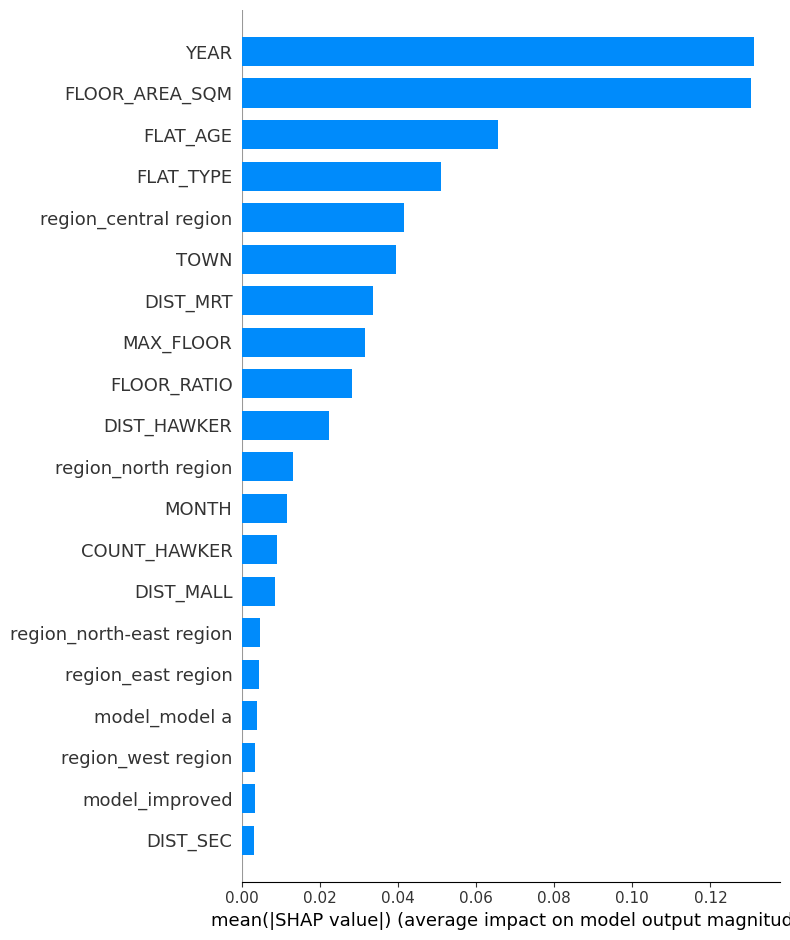

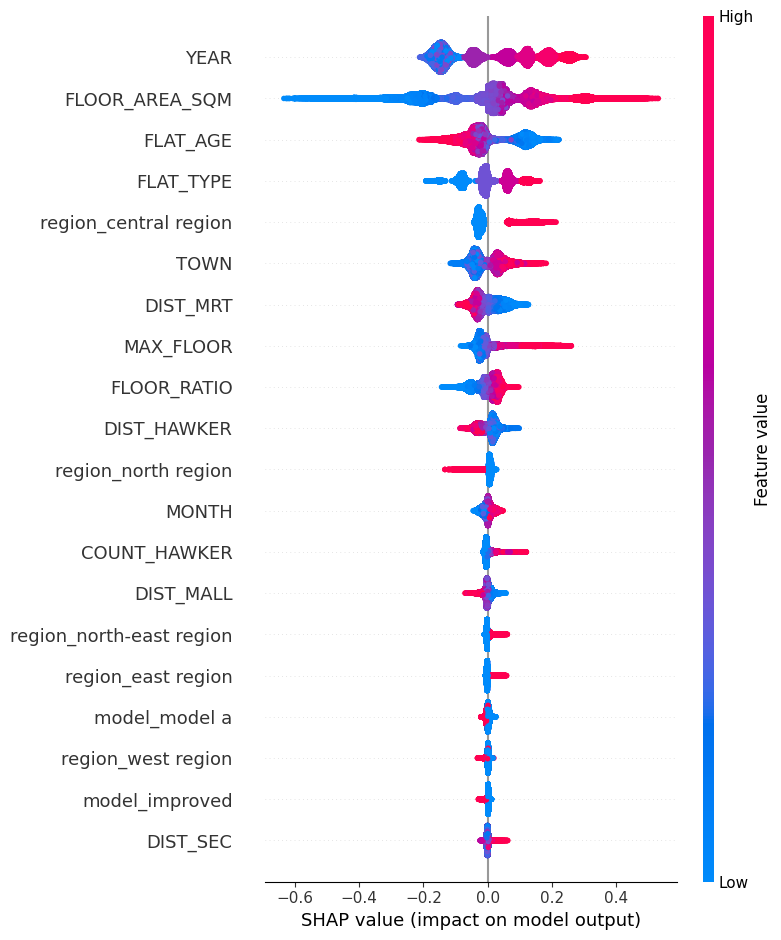

In [6]:
import matplotlib.pyplot as plt
import shap
import joblib
best_model = joblib.load("./best_models/best_lgbm.pkl")

explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_train)

# Plots
shap.summary_plot(shap_values, X_train, plot_type="bar", max_display=20)
shap.summary_plot(shap_values, X_train, max_display=20)


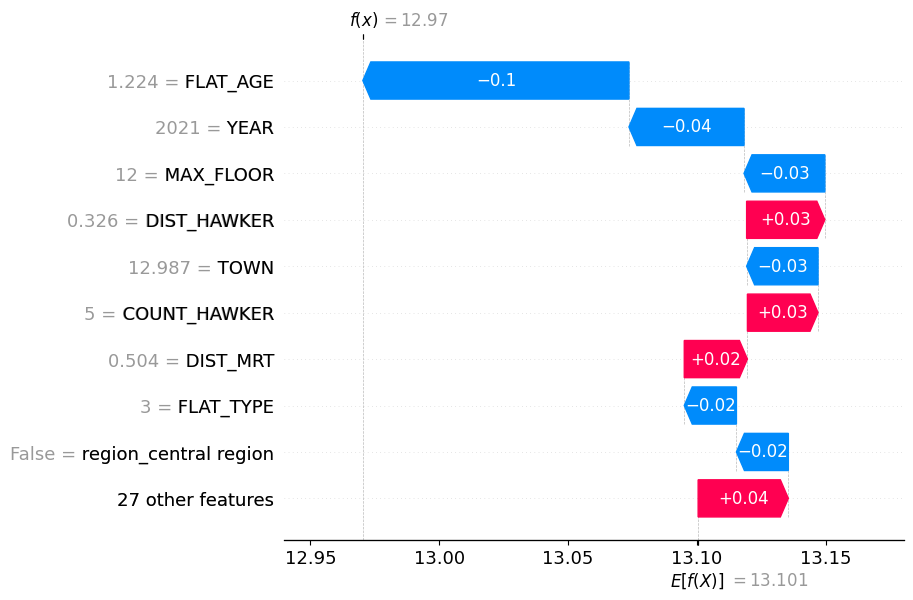

In [5]:
# local explanation for a test sample
i = 0  # test sample index
shap_values_test = explainer(X_test.iloc[i:i+1])
shap.plots.waterfall(shap_values_test[0])

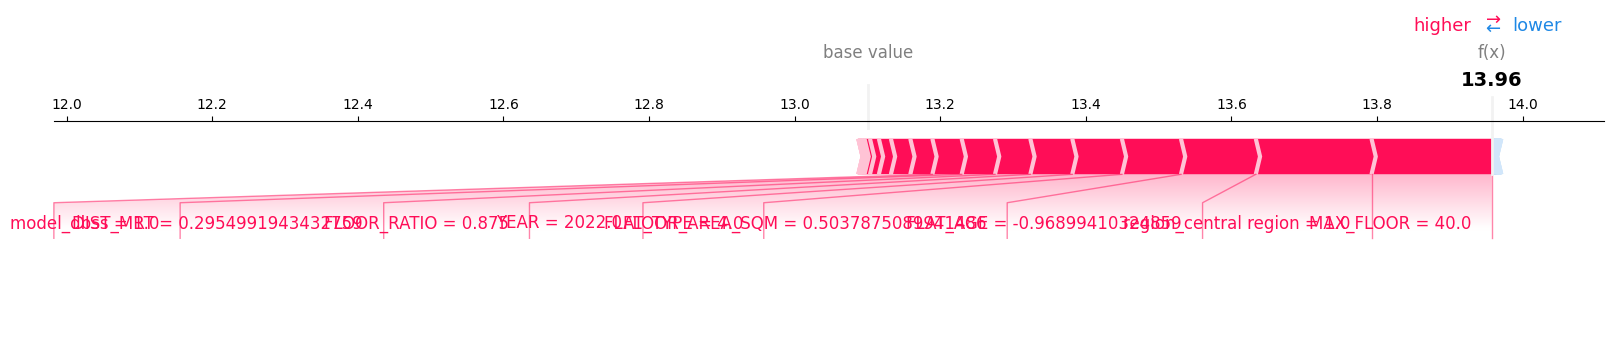

In [6]:
shap.force_plot(
    explainer.expected_value,
    shap_values[i],
    X_train.iloc[i],
    matplotlib=True
)

In [ ]:
# try CatBoost (no need encoding)
# explanability of models - impt features